Imports

In [9]:
#Core Libraries
import pandas as pd
import numpy as np

#Visualization
import matplotlib.pyplot as plt
import seaborn as sns

#Machine Learning Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split

#Evaluation Metrics
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
)


Cleaning Data

In [10]:
import pandas as pd

df = pd.read_csv("rainfall.csv")

df["datetime"] = pd.to_datetime(df["datetime"], format="%d/%m/%y", errors="coerce")

mask = df["datetime"].isna()
df.loc[mask, "datetime"] = pd.to_datetime(df.loc[mask, "datetime"], format="%d-%m-%Y", errors="coerce")

df = df.dropna(subset=["datetime"]).reset_index(drop=True)

cols_to_convert = ["temp", "dew", "humidity", "sealevelpressure",
                   "winddir", "solarradiation", "windspeed",
                   "precipprob", "preciptype"]

for col in cols_to_convert:
    df[col] = pd.to_numeric(df[col], errors="coerce")


df = df.dropna().reset_index(drop=True)


df["preciptype"] = df["preciptype"].astype(int)


print(df.info())
print(df.describe())
print(df.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 708 entries, 0 to 707
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   datetime          708 non-null    datetime64[ns]
 1   temp              708 non-null    float64       
 2   dew               708 non-null    float64       
 3   humidity          708 non-null    float64       
 4   sealevelpressure  708 non-null    float64       
 5   winddir           708 non-null    float64       
 6   solarradiation    708 non-null    float64       
 7   windspeed         708 non-null    float64       
 8   precipprob        708 non-null    int64         
 9   preciptype        708 non-null    int64         
dtypes: datetime64[ns](1), float64(7), int64(2)
memory usage: 55.4 KB
None
                            datetime        temp         dew    humidity  \
count                            708  708.000000  708.000000  708.000000   
mean   2018-06-06 21

In [11]:
df["target"] = df["preciptype"].shift(-1)

df = df.dropna(subset=["target"]).reset_index(drop=True)

#converting to Int
df["target"] = df["target"].astype(int)

#features
feature_cols = ["temp", "dew", "humidity", "sealevelpressure",
                "winddir", "solarradiation", "windspeed", "precipprob"]

X = df[feature_cols]
y = df["target"]


In [12]:
#Creating training and testing split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

#checking balance
print("X_train shape:", X_train.shape)
print("X_test shape :", X_test.shape)
print("y_train distribution:\n", y_train.value_counts())
print("y_test distribution:\n", y_test.value_counts())

X_train shape: (565, 8)
X_test shape : (142, 8)
y_train distribution:
 target
0    295
1    270
Name: count, dtype: int64
y_test distribution:
 target
1    73
0    69
Name: count, dtype: int64


In [13]:
def evaluate_model(name, model, X_train, y_train, X_test, y_test):
    # Test predictions
    y_test_pred = model.predict(X_test)

    # Evaluation metrics
    acc = accuracy_score(y_test, y_test_pred)
    prec = precision_score(y_test, y_test_pred, zero_division=0)
    rec = recall_score(y_test, y_test_pred, zero_division=0)
    f1 = f1_score(y_test, y_test_pred, zero_division=0)
    cm_test = confusion_matrix(y_test, y_test_pred)

    print(f"\n{name} Evaluation (Test):")
    print(f"Accuracy : {acc:.2f}")
    print(f"Precision: {prec:.2f}")
    print(f"Recall   : {rec:.2f}")
    print(f"F1 Score : {f1:.2f}")
    print("Confusion Matrix:")
    print(cm_test)

    #sample predictions
    comparison_df = pd.DataFrame({
        "Actual": y_test.values,
        "Predicted": y_test_pred
    }).reset_index(drop=True)
    print("\nSample Actual vs Predicted:")
    print(comparison_df.head(6))

    #test confusion matrix heatmap
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f"{name} - Test Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("Actual Label")
    plt.tight_layout()
    plt.show()

    #training confusion matrix
    y_train_pred = model.predict(X_train)
    cm_train = confusion_matrix(y_train, y_train_pred)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm_train)
    disp.plot(cmap='Blues')
    plt.title(f"{name} - Training Confusion Matrix")
    plt.tight_layout()
    plt.show()



Logistic Regression Evaluation (Test):
Accuracy : 0.89
Precision: 0.90
Recall   : 0.89
F1 Score : 0.90
Confusion Matrix:
[[62  7]
 [ 8 65]]

Sample Actual vs Predicted:
   Actual  Predicted
0       0          0
1       0          0
2       1          0
3       1          1
4       0          1
5       0          0


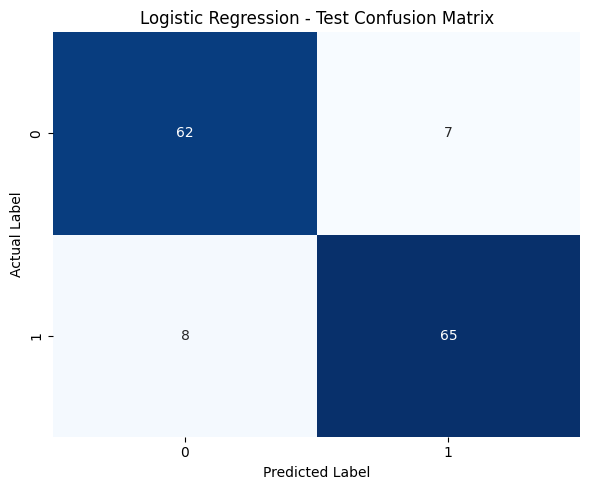

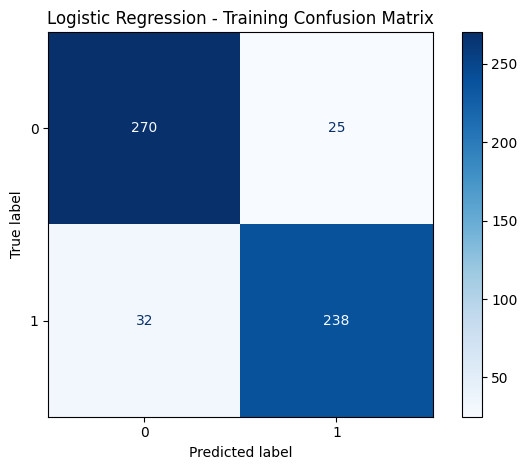

In [14]:
#Logistic Regression 
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)
evaluate_model("Logistic Regression", logreg,X_train, y_train, X_test, y_test)


Decision Tree Evaluation (Test):
Accuracy : 0.85
Precision: 0.85
Recall   : 0.85
F1 Score : 0.85
Confusion Matrix:
[[58 11]
 [11 62]]

Sample Actual vs Predicted:
   Actual  Predicted
0       0          0
1       0          0
2       1          0
3       1          1
4       0          0
5       0          0


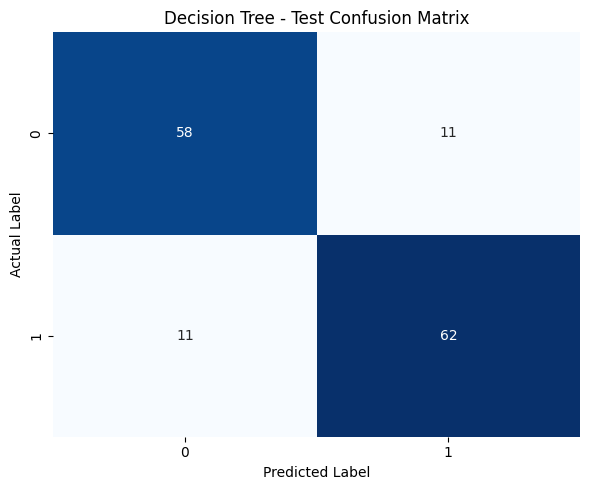

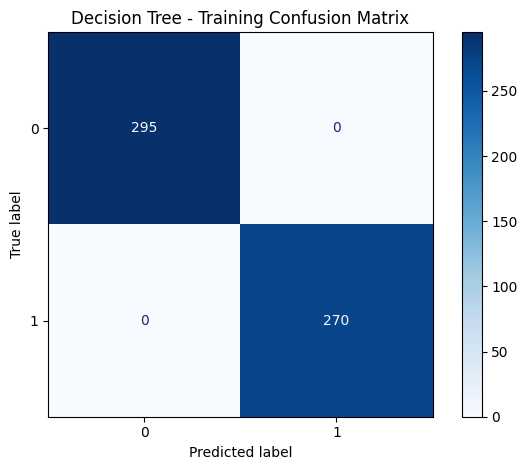

In [15]:
#Decision Tree
dtree = DecisionTreeClassifier(random_state=42)
dtree.fit(X_train, y_train)
evaluate_model("Decision Tree", dtree,X_train, y_train, X_test, y_test)


Random Forest Evaluation (Test):
Accuracy : 0.90
Precision: 0.94
Recall   : 0.86
F1 Score : 0.90
Confusion Matrix:
[[65  4]
 [10 63]]

Sample Actual vs Predicted:
   Actual  Predicted
0       0          0
1       0          0
2       1          0
3       1          1
4       0          0
5       0          0


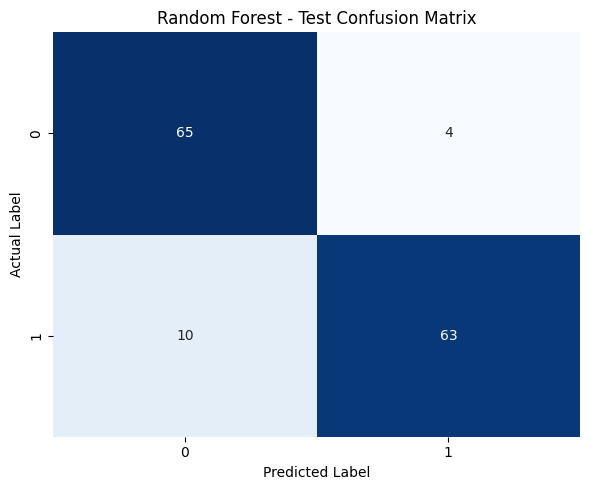

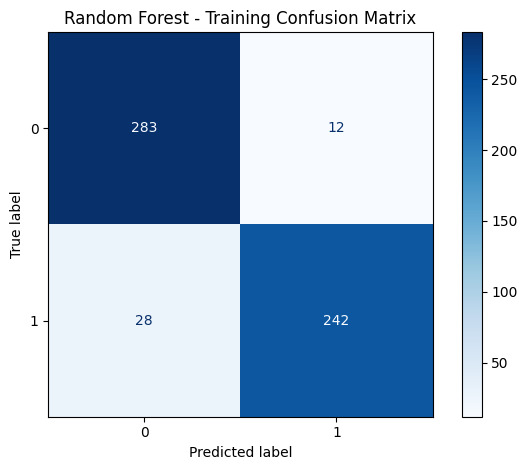

In [16]:
#Random Forest Classifier
rf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
rf.fit(X_train, y_train)
evaluate_model("Random Forest", rf,X_train, y_train, X_test, y_test)


XGBoost Evaluation (Test):
Accuracy : 0.89
Precision: 0.93
Recall   : 0.85
F1 Score : 0.89
Confusion Matrix:
[[64  5]
 [11 62]]

Sample Actual vs Predicted:
   Actual  Predicted
0       0          0
1       0          0
2       1          0
3       1          1
4       0          1
5       0          0


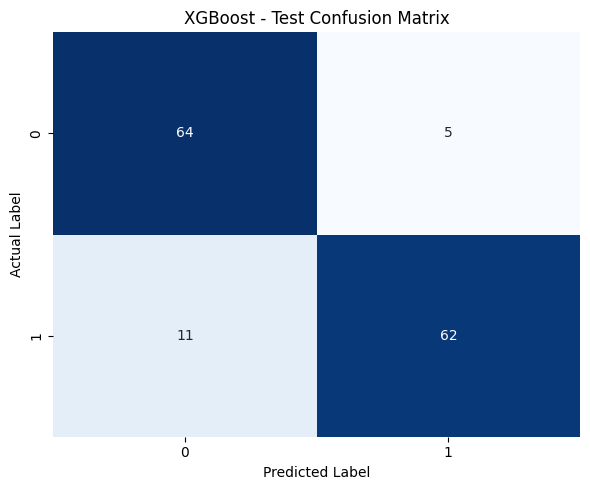

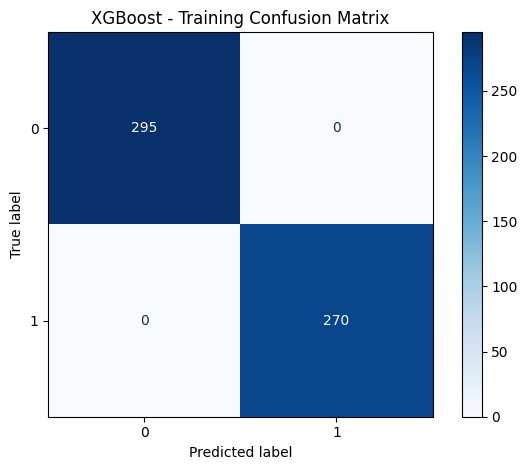

In [17]:
#XGBoost
xgb = XGBClassifier(eval_metric='logloss', random_state=42)
xgb.fit(X_train, y_train)
evaluate_model("XGBoost", xgb,X_train, y_train, X_test, y_test)


SVM Evaluation (Test):
Accuracy : 0.87
Precision: 0.88
Recall   : 0.88
F1 Score : 0.88
Confusion Matrix:
[[60  9]
 [ 9 64]]

Sample Actual vs Predicted:
   Actual  Predicted
0       0          0
1       0          0
2       1          0
3       1          1
4       0          1
5       0          0


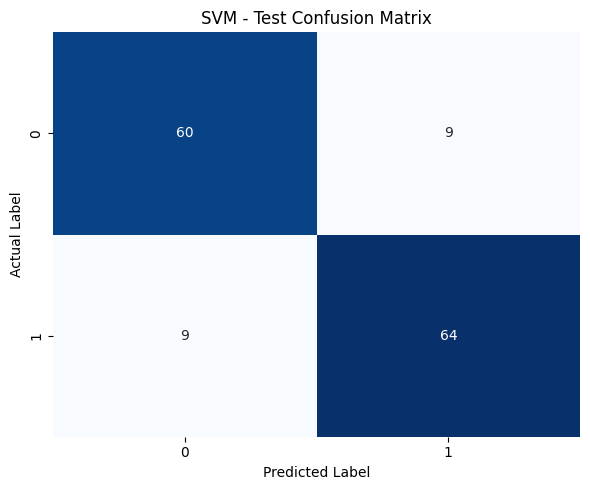

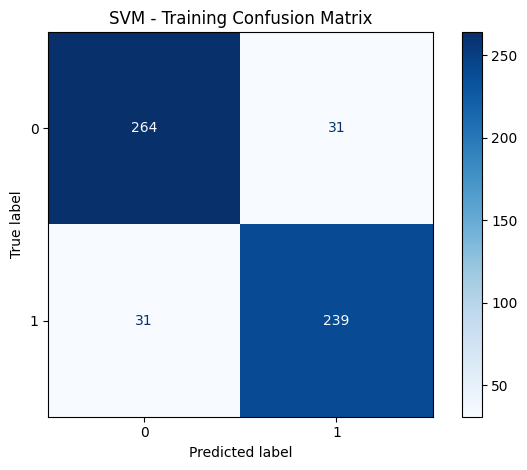

In [18]:
#support vector classifier
svm = SVC(kernel='rbf', probability=True)
svm.fit(X_train, y_train)
evaluate_model("SVM", svm,X_train, y_train, X_test, y_test)


KNN Evaluation (Test):
Accuracy : 0.88
Precision: 0.89
Recall   : 0.88
F1 Score : 0.88
Confusion Matrix:
[[61  8]
 [ 9 64]]

Sample Actual vs Predicted:
   Actual  Predicted
0       0          0
1       0          0
2       1          0
3       1          1
4       0          1
5       0          0


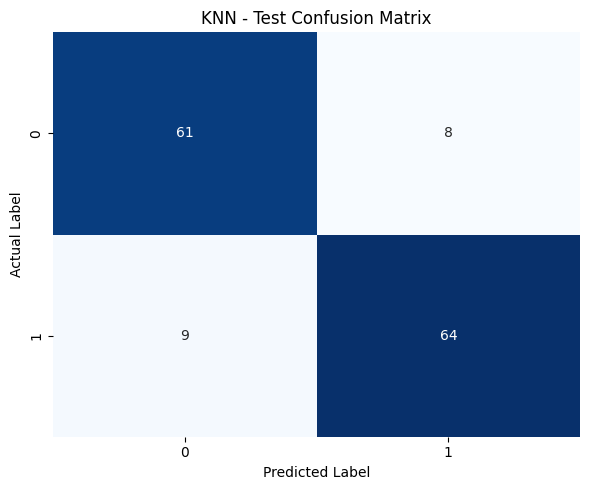

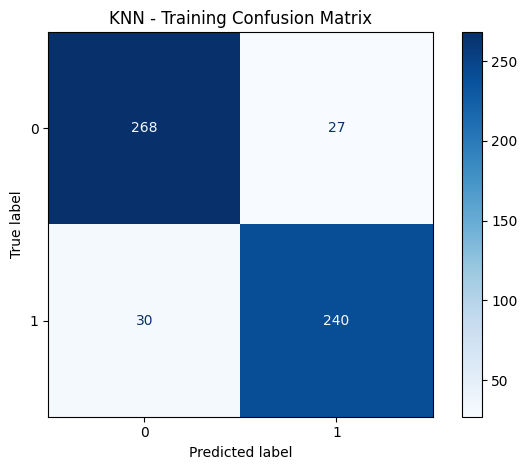

In [19]:
#KNN
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
evaluate_model("KNN", knn,X_train, y_train, X_test, y_test)

Conclusion: As per the testing Random Forest consistently outperformed other models in terms of accuracy, precision, recall, and F1-score, achieving a well-balanced classification output. 

Rainfall is a highly nonlinear and multifactorial phenomenon influenced by various atmospheric and meteorological variables. Accurate classification requires a model that can capture intricate feature interactions while maintaining generalizability. Random Forest proved to be the most suitable algorithm, offering strong predictive performance across all evaluation metrics. 